In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import tensorflow as tf
from PIL import Image
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Conv2D
from keras.layers import Conv1D
from keras.layers import MaxPooling3D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers import Lambda
from keras.layers import Reshape
from keras.layers import BatchNormalization
from keras.layers import GRU
from keras.layers import AveragePooling2D

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import keras.optimizers as ops

Cette fonction reg_data effectue plusieurs étapes de traitement des données sur le DataFrame donné.

Elle supprime les lignes inutiles et la colonne 'MW'.
Elle extrait la date en jours, mois et années à partir de la colonne 'Date'.
Elle corrige les valeurs dans la colonne 'MW' en remplaçant les points par des virgules.
Elle regroupe les données par jour, mois et année, et somme les valeurs de MW.

In [3]:
# création de la fonction qui va traiter les données
def reg_data(df):
      # Suppression des premières lignes inutiles et d'une colonne 'MW'
    df = df.drop(df.index[[0,1,2]])
    df = df.drop('MW', axis=1)
    df.columns = ['Date', 'From', 'to', 'MW']

     # Extraction de la date en jours, mois et années
    dates = df['Date'].tolist()

    days = []
    months = []
    years = []
    for date in dates:
        days.append(date.split('.')[0])
        months.append(date.split('.')[1])
        years.append(date.split('.')[2])

    # Ajout de colonnes pour jours, mois et années
    df['Day'] = days
    df['Month'] = months
    df['Year'] = years

     # Fonction pour corriger les valeurs dans la colonne 'MW'
    def fixMW(cols):
        TT = cols
        TT = TT.replace('.','')
        TT = TT.replace(',','.')
        return TT

    # Application de la fonction fixMW à la colonne 'MW' et conversion en float
    df['MW'] = df['MW'].apply(fixMW).astype(float)
    df['Day'] = df['Day'].astype(int)
    df['Month'] = df['Month'].astype(int)
    df['Year'] = df['Year'].astype(int)

    # Regroupement des données par jour, mois et année et somme des valeurs de MW
    df = df.groupby(['Day','Month','Year'])['MW'].sum()
    df = pd.DataFrame(df)
    df['Month'] = df.index.get_level_values('Month')
    df['Day'] = df.index.get_level_values('Day')
    df['Year'] = df.index.get_level_values('Year')
    df.reset_index(drop=True, inplace=True)
    return df



Ces sections téléchargent les données pour chaque année, les traitent à l'aide de la fonction reg_data, puis les concatènent en une seule DataFrame. Les données sont ensuite standardisées pour les mettre à l'échelle entre 0 et 1.

In [17]:
# Appel de la fonction reg_data pour chaque année de données

Data_10 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2010.csv',sep=';')
Data_10 = reg_data(Data_10)

Data_11 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2011.csv',sep=';')
Data_11 = reg_data(Data_11)

Data_12 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2012.csv',sep=';')
Data_12 = reg_data(Data_12)

Data_13 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2013.csv',sep=';')
Data_13 = reg_data(Data_13)

Data_14 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2014.csv',sep=';')
Data_14 = reg_data(Data_14)
Data_15 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2015.csv',sep=';')
Data_15 = reg_data(Data_15)

Data_16 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2016.csv',sep=';')
Data_16 = reg_data(Data_16)

Data_17 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2017.csv',sep=';')
Data_17 = reg_data(Data_17)
#concatener tout les donnees dans une seule DataFrame
DataFrame = pd.concat([ Data_10, Data_11, Data_12, Data_13,Data_14, Data_15, Data_16, Data_17], ignore_index=True)

In [5]:
DataFrame.head()

,MW,Month,Day,Year
0,332.0,1,1,2010
1,1898.0,2,1,2010
2,2764.0,3,1,2010
3,12736.0,4,1,2010
4,8870.0,5,1,2010


In [6]:
#copier les donnees pour les conserver et travailler seulement avec la copie
model_data = DataFrame

In [7]:
#standarization des donnees
scaler = MinMaxScaler(feature_range=(0, 1))
model_data = scaler.fit_transform(model_data)

# Création de la fonction qui va fractionner les données en Data_train et DataTest
def split_data(df):
    train_size = int(len(df) * 0.75)
    test_size = len(df) - train_size
    train, test = df[0:train_size,:], df[train_size:len(df),:]
    return train, test

#appel de la fonction "split data"
train, test = split_data(model_data)
print(len(model_data))
print(len(train))
print(len(test))

2922
2191
731


Ces parties du code divisent les données en ensembles d'entraînement et de test, puis fractionnent les données en séquences pour être utilisées dans un modèle LSTM. Les données sont également transformées en un format 3D adapté à l'entrée du modèle LSTM.

In [8]:
# Création de la fonction qui va fractionner les données Xtrain et Ytrain puis Xtest et Ytest
def Split_weekly(df, look_back=7):
	dataX, dataY = [], []
	for i in range(len(df)-look_back-1):
		a = df[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(df[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

#Appel de la fonction Split_weekly
Xtrain, Ytrain = Split_weekly(train)
Xtest, Ytest = Split_weekly(test)

print(len(Xtest))
print(len(Ytest))

print(len(Xtrain))
print(len(Ytrain))

723
723
2183
2183


Cette partie du code construit le modèle LSTM à l'aide de Keras Sequential API, l'entraîne sur les données d'entraînement, et évalue sa performance en utilisant la perte sur l'ensemble de validation. Ensuite, le modèle est utilisé pour prédire les valeurs sur l'ensemble de test, et les prédictions sont inversées à l'aide de la mise à l'échelle pour obtenir les valeurs réelles. Enfin, l'erreur quadratique moyenne (MSE) est calculée pour évaluer la performance du modèle.

In [11]:
#transformer la size des donnees en 3D
Xtrain = Xtrain.reshape(Xtrain.shape[0], Xtrain.shape[1], 1)
Xtest = Xtest.reshape(Xtest.shape[0], Xtest.shape[1], 1)

print(Xtest.shape[:])
print(Xtrain.shape[:])

model = Sequential()
model.add(LSTM(units = 8, input_shape=(Xtrain.shape[1], 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 16))
model.add(Dropout(0.2))#drop out overfetting
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer = ops.Nadam(lr=1e-3), loss = 'mse')


model_train = model.fit(Xtrain, Ytrain, validation_split=0.2, epochs=50, batch_size=8, verbose=1)

(723, 7, 1)
(2183, 7, 1)


Epoch 1/50
219/219 [==============================] - 9s 16ms/step - loss: 0.0480 - val_loss: 0.0714
Epoch 2/50
219/219 [==============================] - 3s 12ms/step - loss: 0.0330 - val_loss: 0.0795
Epoch 3/50
219/219 [==============================] - 2s 10ms/step - loss: 0.0310 - val_loss: 0.0686
Epoch 4/50
219/219 [==============================] - 2s 9ms/step - loss: 0.0275 - val_loss: 0.0576
Epoch 5/50
219/219 [==============================] - 2s 10ms/step - loss: 0.0234 - val_loss: 0.0521
Epoch 6/50
219/219 [==============================] - 2s 9ms/step - loss: 0.0211 - val_loss: 0.0487
Epoch 7/50
219/219 [==============================] - 3s 13ms/step - loss: 0.0198 - val_loss: 0.0397
Epoch 8/50
219/219 [==============================] - 4s 19ms/step - loss: 0.0182 - val_loss: 0.0429
Epoch 9/50
219/219 [==============================] - 4s 18ms/step - loss: 0.0176 - val_loss: 0.0376
Epoch 10/50
219/219 [==============================] - 3s 12ms/step - loss: 0.0171 - val_loss

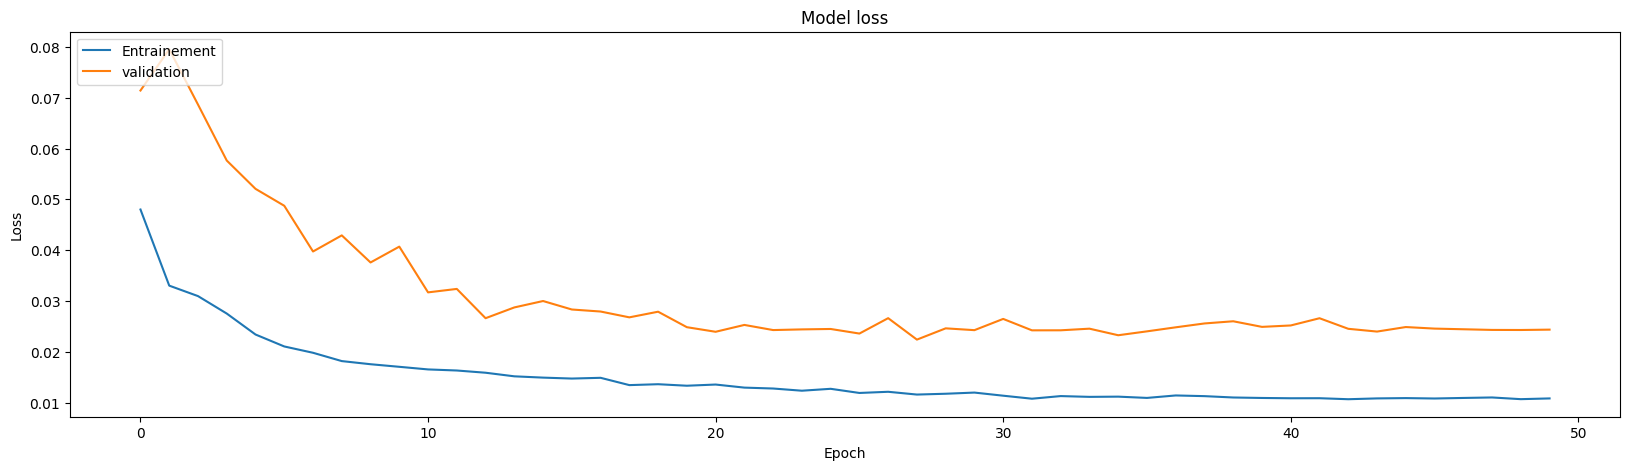

In [12]:
def ploter_Erreur(hist):
    f, axarr = plt.subplots(1,1, figsize=(20, 5))

    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    axarr.set_title('Model loss')
    axarr.set_ylabel('Loss')
    axarr.set_xlabel('Epoch')
    axarr.legend(['Entrainement', 'validation'], loc='upper left')
    plt.show()


ploter_Erreur(model_train)

In [15]:
testPredict = model.predict(Xtest)

scaler2 = MinMaxScaler()
scaler2.min_, scaler2.scale_ = scaler.min_[0], scaler.scale_[0]

testPredict = scaler2.inverse_transform(testPredict)
Ytestp = scaler2.inverse_transform([Ytest])

mean_squared_error(Ytestp[0], testPredict[:,0])



23/23 [==============================] - 0s 4ms/step


2510090532.0911527